# Convergence of the mappings

Study the numerical convergence of mappings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.colors as mplcolors
import numpy as np
from scipy import stats
from neurodyn import *

## Quick test of fast vs naive implementation (sanity check)

In [3]:
def compute_J_ab_naive(rnn: LowRankRNN, n: int, mapping_index: np.ndarray) -> np.ndarray:
	# a naive implementation to test things out, slow !!
	from tqdm import tqdm
	
	_, bin_index_count = np.unique(mapping_index, return_counts=True)
	J = np.zeros((4**n, 4**n), dtype=float)

	for i in tqdm(range(rnn.N)):
		for j in range(rnn.N):
			if i == j: continue  # skip self-connections
			J[mapping_index[i], mapping_index[j]] += (rnn.F[i] * rnn.G[j]).sum()

	J /= rnn.N

	for alpha in range(4):
		J[alpha, :] /= bin_index_count[alpha]

	return J


def compute_J_ab_naive2(rnn: LowRankRNN, n: int, mapping_index: np.ndarray) -> np.ndarray:
	from collections import Counter
	# _, bin_index_count = np.unique(bin_index, return_counts=True)
	bin_index_count = Counter(mapping_index)
	J = np.zeros((4**n, 4**n), dtype=float)

	for alpha in range(4**n):
		if bin_index_count.get(alpha, 0.0) == 0.0: continue
		for beta in range(4**n):
			J[alpha, beta] += np.einsum('im,jm->', rnn.F[mapping_index == alpha, :], rnn.G[mapping_index == beta, :])
			if alpha == beta:  # exclude self connections
				J[alpha, beta] -= np.einsum('im,im->', rnn.F[mapping_index == alpha, :], rnn.G[mapping_index == beta, :])
		# J[alpha, :] /= bin_index_count[alpha]
		J[alpha, :] /= bin_index_count.get(alpha, 0.0)
		
	J /= rnn.N

	return J

def compute_J_ab(rnn: LowRankRNN, n: int, mapping_index: np.ndarray) -> np.ndarray:
	# store the masks, as is expensive in memory ~O(N)
	binmasks: list[np.ndarray] = [ mapping_index == alpha for alpha in range(4**n) ]
	bincounts = np.array([ binmasks[alpha].sum() for alpha in range(4**n) ])
	binF = [ rnn.F[binmasks[alpha], :] for alpha in range(4**n) ]
	binG = [ rnn.G[binmasks[alpha], :] for alpha in range(4**n) ]
	J = np.zeros((4**n, 4**n), dtype=float)

	for alpha in range(4**n):
		if bincounts[alpha] == 0: continue  # empty bins correspond 
		for beta in range(4**n):
			J[alpha, beta] += np.einsum('am,bm->', binF[alpha], binG[beta])
			if alpha == beta:  # exclude self connections
				J[alpha, beta] -= np.einsum('am,am->', binF[alpha], binG[beta])
		J[alpha, :] /= bincounts[alpha]
		
	J /= rnn.N

	return J

In [32]:
rnn = LowRankRNN.new_valentin(p=2, N=1000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
mapping = RecursiveQuadrantMapping(n=1)
mapping_index = mapping.mapping_index(rnn.F)
print(f'{mapping_index[:20]=}')

print('-- naive method --')
print(compute_J_ab_naive(rnn, mapping.n, mapping_index))

print('-- fast method --')
# for this setup : 
# rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
# n = 4
# -> 9.48 s ± 1.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
print(compute_J_ab_naive2(rnn, mapping.n, mapping_index))

print('-- faster method --')
print(compute_J_ab(rnn, mapping.n, mapping_index))
# -> 3.33 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

print('-- implemented -- ')
print(rnn.params.to_binmapped(mapping).to_dense().J)

mapping_index[:20]=array([0, 2, 2, 1, 2, 3, 2, 1, 1, 1, 3, 1, 1, 2, 0, 1, 3, 2, 1, 2])
-- naive method --


100%|██████████| 1000/1000 [00:05<00:00, 180.42it/s]

[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]
-- fast method --
[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]
-- faster method --
[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]
-- implemented -- 
[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]


In [34]:
# without self-connections
LowRankRNNParams.new_valentin(p=2, N=1000, phi=sigmoid, I_ext=zero, exclude_self_connections=False)\
	.to_binmapped(RecursiveQuadrantMapping(n=1))\
	.to_dense().J

array([[ 1.46261282,  0.28966982, -1.98461211,  0.33203223],
       [ 0.22657076,  1.74857855, -0.2716881 , -1.66248461],
       [-1.03859207, -0.20251376,  1.40932715, -0.23897197],
       [ 0.18679833, -1.6010005 , -0.28783173,  1.69022041]])

## Visualize binning of the $J_{ij}$ matrix

In [35]:
params = LowRankRNNParams.new_valentin(p=2, N=1024, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
mapping = RecursiveQuadrantMapping(n=4)  # 4**n = 4**4 = 256 boxes along each axis
mapping_index = mapping.mapping_index(params.F)
mapping_value = mapping(params.F)

# generate dense matrix
idx_sort = np.argsort(mapping_value)
J_dense = params.to_dense().J[idx_sort, :][:, idx_sort]

# bin dense matrix
xx, yy = np.meshgrid(mapping_value[idx_sort], mapping_value[idx_sort])
flatcoords = np.vstack((xx.flatten(), yy.flatten())).T  # we need to flatten J in order to interpolate each component on the (alpha, beta) coordinates
J_binned = stats.binned_statistic_2d(
	flatcoords[:, 0], flatcoords[:, 1], J_dense.flat,
	statistic='sum', bins=[np.linspace(0, 1, mapping.num_bins+1), np.linspace(0, 1, mapping.num_bins+1)],
).statistic

# rescale
J_rescaled = J_binned.copy()
J_rescaled = np.nan_to_num(J_rescaled, nan=0.0)
for alpha in range(mapping.num_bins):
	bincount = (mapping_index == alpha).sum()
	if bincount == 0: continue
	J_rescaled[alpha, :] /= bincount
# J_rescaled /= rnn.N  # we don't need to rescale by N, because J is already divided by N

# the mathematically true result
J_ab = params.to_binmapped(mapping).to_dense().J

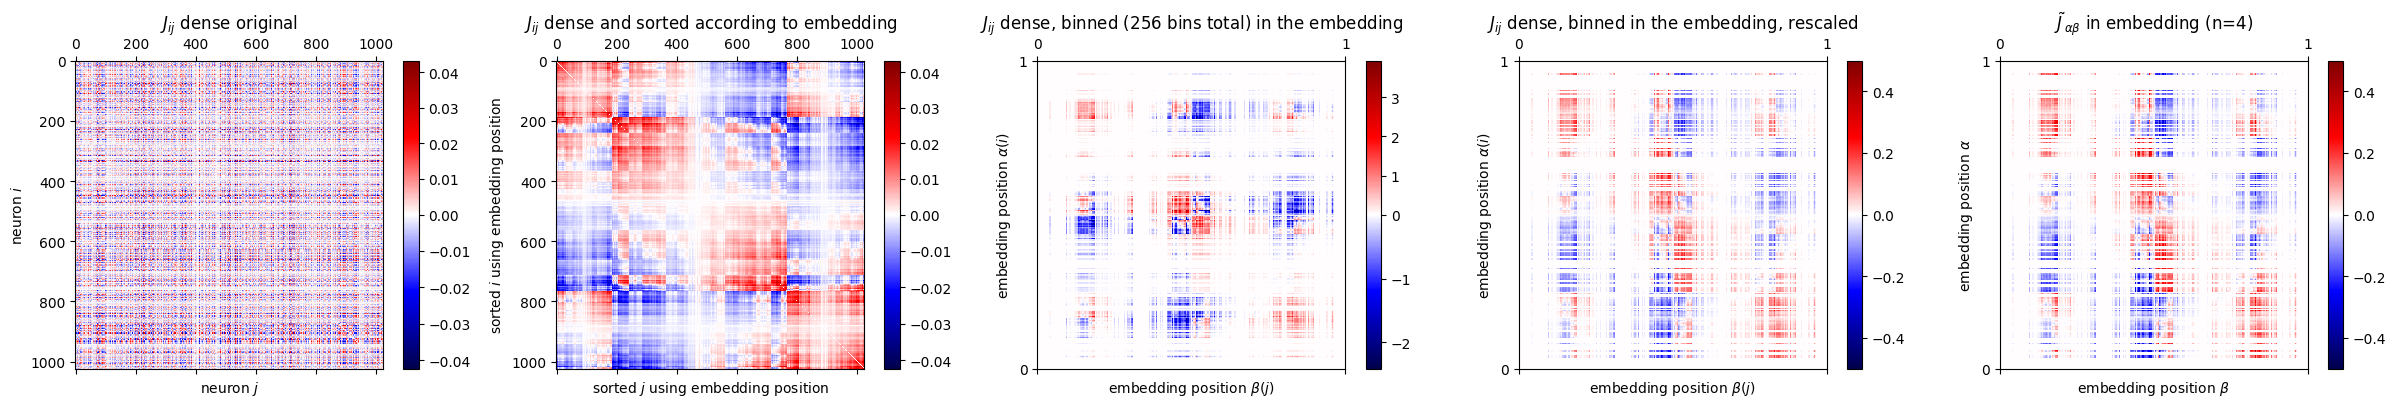

In [38]:
fig, axes = plt.subplots(figsize=(30, 4), ncols=5)

axes[0].set_title('$J_{ij}$ dense original')
axes[0].set_xlabel('neuron $j$')
axes[0].set_ylabel('neuron $i$')
axes[1].set_title('$J_{ij}$ dense and sorted according to embedding')
axes[1].set_xlabel('sorted $j$ using embedding position')
axes[1].set_ylabel('sorted $i$ using embedding position')
axes[2].set_title(f'$J_{{ij}}$ dense, binned ({mapping.num_bins} bins total) in the embedding')
axes[2].set_xlabel('embedding position $\\beta(j)$')
axes[2].set_ylabel('embedding position $\\alpha(i)$')
axes[3].set_title('$J_{ij}$ dense, binned in the embedding, rescaled')
axes[3].set_xlabel('embedding position $\\beta(j)$')
axes[3].set_ylabel('embedding position $\\alpha(i)$')
axes[4].set_title(f'$\\tilde J_{{\\alpha\\beta}}$ in embedding (n={mapping.n})')
axes[4].set_xlabel('embedding position $\\beta$')
axes[4].set_ylabel('embedding position $\\alpha$')

im = axes[0].matshow(params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0))
fig.colorbar(im, ax=axes[0])

im = axes[1].matshow(J_dense, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0))
fig.colorbar(im, ax=axes[1])

im = axes[2].matshow(J_binned, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[2])

im = axes[3].matshow(J_rescaled, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0, vmin=-0.5, vmax=0.5), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[3])

im = axes[4].matshow(J_ab, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0, vmin=-0.5, vmax=0.5), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[4])

plt.show()

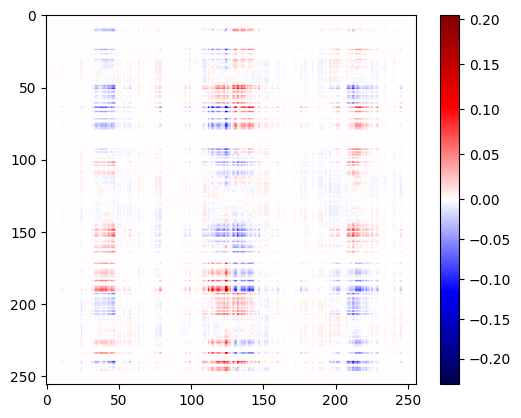

In [39]:
# TODO : why do we still see some difference ? Are these just numerical inaccuracies ?
plt.imshow(J_rescaled - J_ab, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0))
plt.colorbar();

## Simulate convergence

simulating LowRankRNN{N=20000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:01<00:00]


LowRankRNN{N=20000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}


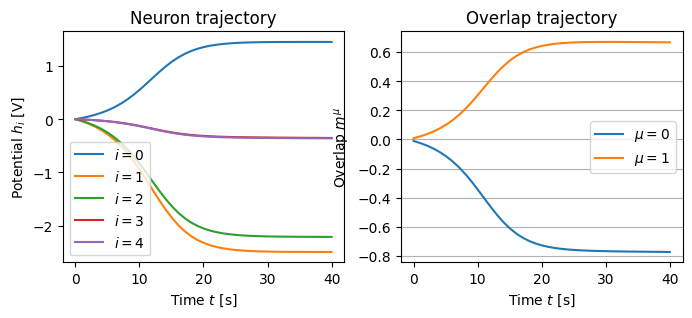

In [40]:
rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
# res = rnn.simulate(h0=rnn.F[:, 0], t_span=(0, 40), dt_max=0.5, progress=True)  # TODO : how do we adapt the mu patterns to the embedding ?
res = rnn.simulate(h0=np.zeros(rnn.N), t_span=(0, 40), dt_max=1, progress=True)
print(rnn)
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
plot_neuron_trajectory(res, figax=(fig, axes[0]));
plot_overlap_trajectory(rnn, res, figax=(fig, axes[1]));

In [43]:
mapping = RecursiveQuadrantMapping(n=5)
rnn_dense = DenseRNN(rnn.params.to_binmapped(mapping).to_dense())
print(rnn_dense)

DenseRNN{N=1024, phi=sigmoid, I_ext=zero, exclude_self_connections=True}


In [44]:
res_dense = rnn_dense.simulate(h0=np.zeros(rnn_dense.N), t_span=(0, 40), dt_max=1, progress=True)

simulating DenseRNN{N=1024, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:01<00:00]


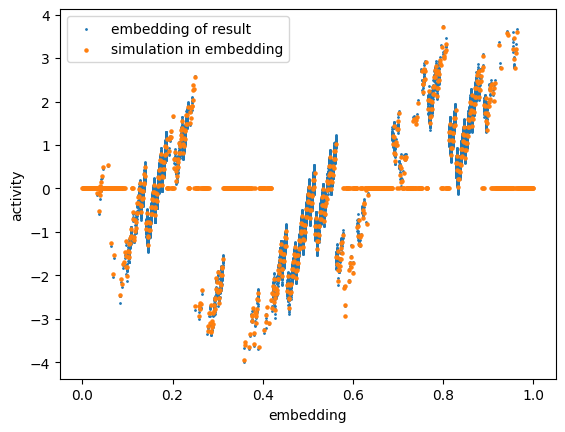

In [45]:
fig, ax = plt.subplots()
ax.scatter(mapping(rnn.F), res.h[:, -1], s=1, label='embedding of result')
ax.scatter(np.linspace(0, 1, mapping.num_bins), res_dense.h[:, -1], s=5, label='simulation in embedding')
ax.legend()
ax.set_xlabel('embedding')
ax.set_ylabel('activity')
plt.show()

In [216]:
# TODO : how do we compute overlap on the embedded RNN ?

In [ ]:
# TODO : run with more neurons